In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.layers import Dense,Dropout,Activation,LSTM
from keras.layers.embeddings import Embedding
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import time
from keras.models import Sequential
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer 
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.model_selection import train_test_split

from PIL import Image 

from bs4 import BeautifulSoup 
from selenium import webdriver 
import networkx as nx 

import pickle
import warnings 
warnings.filterwarnings('ignore')

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
all_urls = pd.read_csv('phishing_site_urls.csv')

In [5]:
all_urls.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [6]:
all_urls[all_urls['Label']=='bad']

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


In [7]:
all_urls[all_urls['Label']=='good']

,URL,Label
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good
...,...,...
483590,youthleaguesusa.com/potomacsoccer/2011/Tournam...,good
483591,zip-codes.com/,good
483592,owens.edu/news-releases/?p=2052,good
483593,1.safesecureweb.com/egale/index.asp?item=1173,good


In [8]:
all_urls.isnull().sum()

URL      0
Label    0
dtype: int64

In [9]:
label_counts = pd.DataFrame(all_urls.Label.value_counts())
label_counts

,Label
good,392924
bad,156422


<BarContainer object of 2 artists>

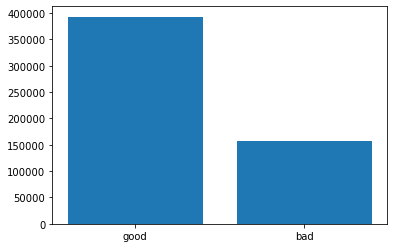

In [10]:
fig,ax = plt.subplots();
plt.bar(label_counts.index,label_counts.Label)

In [11]:
all_urls.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [12]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
tokenizer.tokenize(all_urls.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [13]:
all_urls['text_tokenized'] = all_urls.URL.map(lambda t: tokenizer.tokenize(t))

In [14]:
all_urls.head()

,URL,Label,text_tokenized
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi..."


In [15]:
stemmer = SnowballStemmer("english") 

In [16]:
all_urls['text_stemmed'] = all_urls['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
all_urls['text_stemmed'][0]

['nobel',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'skype',
 'com',
 'en',
 'cgi',
 'bin',
 'verif',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profil',
 'ach',
 'outdat',
 'page',
 'tmpl',
 'p',
 'gen',
 'fail',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [17]:
all_urls['text'] = all_urls['text_stemmed'].map(lambda l: ' '.join(l))
all_urls.head()

,URL,Label,text_tokenized,text_stemmed,text
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [18]:
bad_sites = all_urls[all_urls.Label == 'bad']
good_sites = all_urls[all_urls.Label == 'good']

In [19]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [20]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [21]:
all_urls['Label'] = all_urls['Label'].replace(to_replace=['bad', 'good'], value=[0, 1])
all_urls_sample = all_urls.sample(n=10000)
all_urls_sample.head()

,URL,Label,text_tokenized,text_stemmed,text
397380,mylife.com/mikemccolman,1,"[mylife, com, mikemccolman]","[mylif, com, mikemccolman]",mylif com mikemccolman
479194,zetaminor.com/dvd/dvdreviews/pitch_black.htm,1,"[zetaminor, com, dvd, dvdreviews, pitch, black...","[zetaminor, com, dvd, dvdreview, pitch, black,...",zetaminor com dvd dvdreview pitch black htm
327914,facebook.com/lucybrucenaylor,1,"[facebook, com, lucybrucenaylor]","[facebook, com, lucybrucenaylor]",facebook com lucybrucenaylor
67851,tools.ietf.org/html/rfc1968,1,"[tools, ietf, org, html, rfc]","[tool, ietf, org, html, rfc]",tool ietf org html rfc
238963,shop.nick.com/category/48046660381/1/Blues-Clu...,1,"[shop, nick, com, category, Blues, Clues, htm]","[shop, nick, com, categori, blue, clue, htm]",shop nick com categori blue clue htm


In [22]:
all_urls_sample['URL']

397380                              mylife.com/mikemccolman
479194         zetaminor.com/dvd/dvdreviews/pitch_black.htm
327914                         facebook.com/lucybrucenaylor
67851                           tools.ietf.org/html/rfc1968
238963    shop.nick.com/category/48046660381/1/Blues-Clu...
                                ...                        
544173                    regionalclaimsrecovery.com/87nft3
121195         srhralliance.or.ke/libraries/emb/excel/excel
12477     entretecno.cl/includes/facte/d66d798f8546172f3...
424409    roofing-directory.com/new-jersey/hunterdon-cou...
50513                      home.earthlink.net/~townsen1895/
Name: URL, Length: 15000, dtype: object

In [23]:
browser = webdriver.Chrome(r"C:\Users\Poorvi Hegde\Downloads\chromedriver_win32\chromedriver.exe")

In [24]:
list_urls = ['https://sites.google.com/site/libretyreserve/'] 
links_with_text = []

In [25]:
import requests
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }
for url in list_urls:
    #browser.get(url)
    req = requests.get(url,headers)
    soup = BeautifulSoup(req.content,"html.parser")
    for line in soup.find_all('a'):
        href = line.get('href')
        links_with_text.append([url, href])

In [26]:
links_with_text

[['https://sites.google.com/site/libretyreserve/',
  'https://sites.google.com/site/libretyreserve/'],
 ['https://sites.google.com/site/libretyreserve/',
  '/site/libretyreserve/system/app/pages/sitemap/hierarchy'],
 ['https://sites.google.com/site/libretyreserve/',
  'http://www.libertyreserve.com/'],
 ['https://sites.google.com/site/libretyreserve/', None],
 ['https://sites.google.com/site/libretyreserve/',
  'https://www.libertyreserve.com/en/reporterror'],
 ['https://sites.google.com/site/libretyreserve/',
  'https://www.libertyreserve.com/en/login'],
 ['https://sites.google.com/site/libretyreserve/', None],
 ['https://sites.google.com/site/libretyreserve/',
  'http://www.libertyreserve.com/en/home/corporate'],
 ['https://sites.google.com/site/libretyreserve/',
  'http://www.libertyreserve.com/en/home/termsofservice'],
 ['https://sites.google.com/site/libretyreserve/',
  'http://www.libertyreserve.com/en/home/privacypolicy'],
 ['https://sites.google.com/site/libretyreserve/',
  'ht

In [27]:
df = pd.DataFrame(links_with_text, columns=["from", "to"])
df = df.replace(to_replace='None', value=np.nan).dropna()
df

,from,to
0,https://sites.google.com/site/libretyreserve/,https://sites.google.com/site/libretyreserve/
1,https://sites.google.com/site/libretyreserve/,/site/libretyreserve/system/app/pages/sitemap/...
2,https://sites.google.com/site/libretyreserve/,http://www.libertyreserve.com/
4,https://sites.google.com/site/libretyreserve/,https://www.libertyreserve.com/en/reporterror
5,https://sites.google.com/site/libretyreserve/,https://www.libertyreserve.com/en/login
7,https://sites.google.com/site/libretyreserve/,http://www.libertyreserve.com/en/home/corporate
8,https://sites.google.com/site/libretyreserve/,http://www.libertyreserve.com/en/home/termsofs...
9,https://sites.google.com/site/libretyreserve/,http://www.libertyreserve.com/en/home/privacyp...
10,https://sites.google.com/site/libretyreserve/,http://www.libertyreserve.com/en/home/amlpolicy
11,https://sites.google.com/site/libretyreserve/,https://www.libertyreserve.com/en/contactus


In [28]:
df.head()

,from,to
0,https://sites.google.com/site/libretyreserve/,https://sites.google.com/site/libretyreserve/
1,https://sites.google.com/site/libretyreserve/,/site/libretyreserve/system/app/pages/sitemap/...
2,https://sites.google.com/site/libretyreserve/,http://www.libertyreserve.com/
4,https://sites.google.com/site/libretyreserve/,https://www.libertyreserve.com/en/reporterror
5,https://sites.google.com/site/libretyreserve/,https://www.libertyreserve.com/en/login


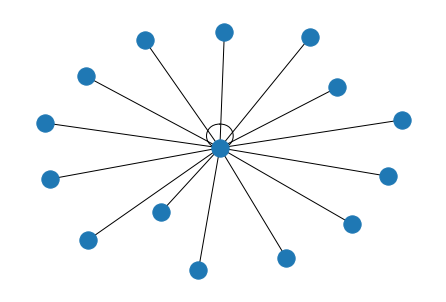

In [29]:
import networkx as nx
GA = nx.from_pandas_edgelist(df, source="from", target="to")
nx.draw(GA, with_labels=False)

In [30]:
trainX, testX, trainY, testY = train_test_split(all_urls_sample.text, all_urls_sample.Label,train_size=0.8,test_size=0.2)

In [31]:
cv = CountVectorizer()

In [32]:
feature = cv.fit(all_urls_sample.text)

In [33]:
X_train = feature.transform(trainX)
X_test = feature.transform(testX)

In [34]:
trainY

160469    1
204641    1
406561    1
503953    0
195414    1
         ..
433981    1
35864     0
30011     0
526121    0
187279    1
Name: Label, Length: 12000, dtype: int64

In [35]:
X_train

<12000x27200 sparse matrix of type '<class 'numpy.int64'>'
	with 81654 stored elements in Compressed Sparse Row format>

In [36]:
X_train.shape

(12000, 27200)

In [37]:
model_ann = Sequential()
input_dim = X_train.shape[1]
model_ann.add(layers.Dense(16,input_dim=input_dim,activation = 'relu'))
model_ann.add(layers.Dense(8,activation = 'relu'))
model_ann.add(layers.Dense(1,activation='relu'))
model_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                435216    
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 435,361
Trainable params: 435,361
Non-trainable params: 0
_________________________________________________________________


In [38]:
X_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [39]:
X_train.shape

(12000, 27200)

In [40]:
model_ann.fit(X_train.toarray(), trainY, epochs=10, verbose=True, batch_size = 20)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [88]:
predicted_test = model_ann.predict(X_train)

In [89]:
predicted_test

array([[1.5762395],
       [0.       ],
       [1.3838831],
       ...,
       [2.1992168],
       [1.4531596],
       [0.0935158]], dtype=float32)

In [90]:
train_loss, train_accuracy= model_ann.evaluate(X_train.toarray(), trainY, verbose=False)
print('train accuracy', train_accuracy)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [91]:
test_loss, test_accuracy= model_ann.evaluate(X_test.toarray(), testY, verbose=False)
print('test accuracy', test_accuracy)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.